In [1]:
import meep as mp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
print(mp.__version__)

from numpy.fft import fft, ifft, fftfreq

1.23.0


/tmp/ipykernel_288/3848151376.py:5: RuntimeWarning: invalid value encountered in true_divide
  f1 = x /tmp ## there is a warning since tmp[0] = 0


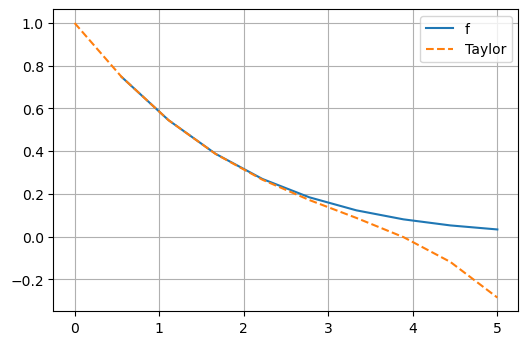

In [4]:
## Test the equation
Nx = 10
x = np.linspace(0,5,Nx)
tmp = np.exp(x) -1
f1 = x /tmp ## there is a warning since tmp[0] = 0
f2 = 1 - x/2 + x **2/12 -x**4/720
##
fig = plt.figure(dpi=100)
plt.plot(x,f1,label='f')
plt.plot(x,f2,'--',label='Taylor')
plt.grid()
plt.legend()
plt.show()

In [11]:
##

resolution = 50               # pixels/um
dpml = 1.0                      # PML thickness
sz = 16 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

dimensions = 1
tsim = 1000
courant = 0.5 
dt = courant  / resolution
Nt = int(tsim/dt + 1)
tslice = np.linspace(0, tsim, Nt)
hb=1.05459*10**(-34)
c=3*10**8
epsilon = 8.854*10**(-12)
k= 1.38*10**(-23)
tau = 2*Nt*2*10**(-15)

##
omegal = 2 * np.pi / Nt * np.linspace(0,Nt-1,Nt) 
ml = np.random.normal(0,1,Nt)
nl = np.random.normal(0,1,Nt)

In [17]:
##

def Dnsqr(omega,T):
    x = np.abs(omega/T)
    if x > 1e-3:
        tmp = abs(omega)*hb / (np.exp(abs(omega)*hb/T/k)-1) / np.pi/c 
        output = 6*hb /T**2/k**2  * tmp *c
    else:
        output = 6 /np.pi/T * (1 - x/2 + x **2/12 -x**4/720) ## Taylor expansion
    
    output = np.sqrt(output)
    return output

tempe = 50000
dlsqr = np.empty(Nt)

for i in range(Nt):
     dlsqr[i] = Dnsqr(omegal[i],tempe) 
def rms(temperature):
    return((((2/(epsilon*6*hb*c))**0.5)*k*temperature))
delta = rms(50000)
fc = delta*(ml + 1j * nl) * dlsqr/tau**0.5 ## Fourier component from Eq. 6        

## use fft to generate signal
ts1 = time.time()

  

Ef = ifft(fc)

te1 = time.time()

## use for loop to generate signal

#Ef2 =np.empty(Nt) 

#ts2 = time.time()

#Ef2 = np.zeros(Nt,dtype=complex)

#for i in range(Nt):
      #Ef2[i] = sum( fc * np.exp(1j * omegal * i))/Nt

#te2 = time.time()

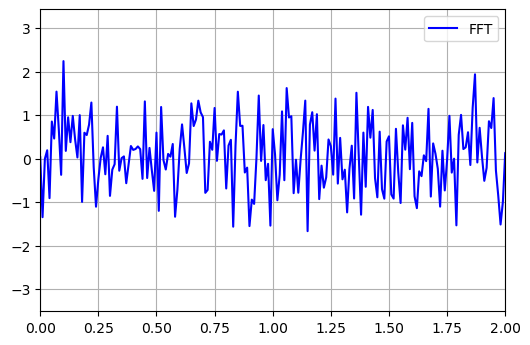

using FFT 0.02408003807067871
prediction by complexity: Nt /log2(Nt) = 6020.654889830512


In [18]:
##
fig = plt.figure(dpi=100)
plt.plot(tslice,np.real(Ef),'b',label = 'FFT',linewidth=1.5)
#plt.plot(tslice,np.real(Ef2),'g--', label = 'For loop',linewidth=1.5)
plt.xlim(0,2)
#plt.ylim(-0.008,0.008)
plt.legend()
plt.grid()
plt.show()

print('using FFT', te1-ts1)
#print('using for loop', te2-ts2)
#print('ratio of computation time =', (te2-ts2)/(te1-ts1)) 
print('prediction by complexity: Nt /log2(Nt) =', Nt/np.log2(Nt)) 

In [30]:
import meep as mp
cell = mp.Vector3(16,8,0)
pml_layers = [mp.PML(1.0)]
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     amp_func=Ef,
                     center=mp.Vector3(-7,0))]

In [31]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution)

In [33]:
sim.run

<bound method Simulation.run of <meep.simulation.Simulation object at 0x7f09f593cd00>>

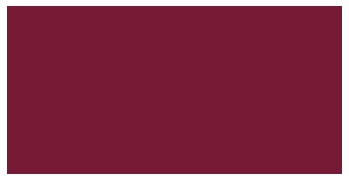

In [34]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()